In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = "datasets/Hirano3D/"
# data_path = Path(PATH)

In [4]:
NUM_CLASSES = 4
bs = 64
sz = [4,224,224]

In [5]:
_clss = {'NM17-002': 0,
         'Ctrl-AK': 0,
         'GUK1-D': 1, 
         'GUK1-R': 1,
         'MFN2-1': 2,
         'VCP-1': 3}

#### CV generation via sklearn, Multilabel implementation by trent-b, or FastAi

Both libraries seem to be completely useless... can just use native fastai function: get_cv_idxs().<br>
However, get_cv_idxs() does NOT shuffle...!

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_label_stratified_CV_idxs2(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### sklearn.model_selection.StratifiedKFold
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    
    for train_index, val_index in sss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def get_label_stratified_CV_idxs(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
#     _all_labels['fake'] = pd.Series(np.zeros(len(_all_labels), dtype=int)) #need fake secondary-label column
    _all_labels['fake'] = _all_labels.Targets.copy() #need fake secondary-label column
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### Iterative stratification library: https://github.com/trent-b/iterative-stratification
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    
    for train_index, val_index in msss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs

In [8]:
### used atm...
csv_path = path + '16bit_multi_folder_Hirano3D_v1.csv'
trn_idxs, val_idxs = get_label_stratified_CV_idxs2(csv_path)

Train label-distribution:
0    216
1    163
2    161
3    124
dtype: int64
Val label-distribution:
0    54
1    41
2    40
3    31
dtype: int64


In [ ]:
# csv_path = path + 'multi_folder_Hirano3D_02.csv'
# trn_idxs, val_idxs = get_label_stratified_CV_idxs(csv_path)

In [ ]:
# setting up a list of a random 20% of images in train as the validation set

# lbl_csv = path + 'multi_folder_Hirano3D_02.csv'
# n = len(list(open(lbl_csv))) -1
# val_idxs = get_cv_idxs(n, val_pct=0.2)


# # Count labels
# # _all_labels = pd.read_csv(PATH + 'multi_folder_Hirano3D_02.csv')
# # print(_all_labels.Targets.value_counts())

# _arr = _all_labels.values
# _val_labels = pd.DataFrame(_arr[val_idxs], columns=['Id','Targets'])
# print(_val_labels.Targets.value_counts())

### Define Dataloader:

In [9]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'data', lbl_csv, 
                                        val_idxs = val_idxs,
                                        test_name='data/16bit_Hirano3D_MaxP_GRFB_test_512', 
                                        tfms=tfms, bs=bs, suffix = '.tif', 
                                        balance=True)
    return data

In [10]:
PATH = "datasets/Hirano3D/"
# data_path = Path(PATH)

In [11]:
# define augmentations
augs = [RandomDihedral()]

# csv:
lbl_csv = path + '16bit_multi_folder_Hirano3D_v1.csv'

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

Internal Normalization
val_crop is: 2
Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


### inpsect data_loaders

In [ ]:
x, y = next(iter(data.trn_dl))
# x_test, y_test = next(iter(data.test_dl))

In [ ]:
plt.imshow(to_np(x)[5][2])

In [ ]:
# loading epoch for manual inspection...

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


### inpsecting loaded images and labels

In [ ]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

In [ ]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_np(y)[idx]
# lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [ ]:
torch.cuda.is_available()

In [12]:
# base-model

arch = resnet18_c
# arch = resnet50
learn = ConvLearner.pretrained(arch, data, ps=0.25, opt_fn=optim.Adam, pretrained=False)

In [13]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
# learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [14]:
learn.unfreeze()

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
# training loops:

In [15]:
%time learn.fit(1e-3, 8, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                              
epoch      trn_loss   val_loss   accuracy   
    0      1.517403   2.20572    0.210843  
EPOCH 1 ---------------------------------------- STEP 1                                                                                                                                                              
    1      1.446878   2.080296   0.26506   
EPOCH 2 ---------------------------------------- STEP 2                                                                                                                                                              
    2      1.40584    1.464769   0.409639  
EPOCH 3 ---------------------------------------- STEP 3                                                                                                                              

[array([1.143]), 0.5120481916938919]

In [16]:
%time learn.fit(1e-3, 8, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 8                                                                                                                                                              
epoch      trn_loss   val_loss   accuracy   
    0      1.23694    1.940466   0.228916  
EPOCH 1 ---------------------------------------- STEP 9                                                                                                                                                              
    1      1.184067   1.384985   0.451807  
EPOCH 2 ---------------------------------------- STEP 10                                                                                                                                                             
    2      1.149106   1.60902    0.39759   
EPOCH 3 ---------------------------------------- STEP 11                                                                                                                             

[array([1.59728]), 0.42168674734701594]

In [17]:
%time learn.fit(8e-4, 32, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 16                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.973382   2.170615   0.313253  
EPOCH 1 ---------------------------------------- STEP 17                                                                                                                                                             
    1      0.931949   1.481722   0.493976  
EPOCH 2 ---------------------------------------- STEP 18                                                                                                                                                             
    2      0.939776   1.041025   0.572289  
EPOCH 3 ---------------------------------------- STEP 19                                                                                                                             

EPOCH 31 ---------------------------------------- STEP 47                                                                                                                                                            
    31     0.474696   4.740773   0.253012  

appending existing log-files...
log-files saved to: datasets/Hirano3D/
Wall time: 8min 30s


[array([4.74077]), 0.2530120494494955]

In [18]:
%time learn.fit(6e-4, 16, cycle_len=1, wds=wd, use_wd_sched=True, best_save_name='H3D_Res18_local_v3_1')

EPOCH 0 ---------------------------------------- STEP 48                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.392256   1.43872    0.560241  
EPOCH 1 ---------------------------------------- STEP 49                                                                                                                                                             
    1      0.396128   1.599786   0.578313  
EPOCH 2 ---------------------------------------- STEP 50                                                                                                                                                             
    2      0.350987   1.365139   0.60241   
EPOCH 3 ---------------------------------------- STEP 51                                                                                                                             

[array([1.50479]), 0.5662650537778096]

In [19]:
%time learn.fit(1e-4, 16, cycle_len=1, wds=wd, use_wd_sched=True, best_save_name='H3D_Res18_local_v3_2')

EPOCH 0 ---------------------------------------- STEP 64                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.148897   1.364937   0.638554  
EPOCH 1 ---------------------------------------- STEP 65                                                                                                                                                             
    1      0.125087   1.264435   0.626506  
EPOCH 2 ---------------------------------------- STEP 66                                                                                                                                                             
    2      0.111476   1.268848   0.650602  
EPOCH 3 ---------------------------------------- STEP 67                                                                                                                             

[array([1.37516]), 0.6325301154550299]

In [ ]:
lr = (5e-4, 1e-3, 5e-3)

In [20]:
sz = [4,512, 512]
learn.set_data(get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs))

Internal Normalization
val_crop is: 2
Calculating weights...
one-hot encoding single-labels...
Weights calculated successfully!
Using WeightedRandomSampler


In [21]:
%time learn.fit(1e-4, 1, cycle_len=8, cycle_mult=2, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 80                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      1.15899    1.962104   0.536145  
EPOCH 1 ---------------------------------------- STEP 81                                                                                                                                                             
    1      1.13715    1.633762   0.578313  
EPOCH 2 ---------------------------------------- STEP 82                                                                                                                                                             
    2      1.074423   1.568484   0.578313  
EPOCH 3 ---------------------------------------- STEP 83                                                                                                                             

[array([1.49841]), 0.5783132522939199]

In [22]:
%time learn.fit(2e-4, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='H3D_Res18_local_v3_3')

EPOCH 0 ---------------------------------------- STEP 88                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.918284   1.462105   0.572289  
EPOCH 1 ---------------------------------------- STEP 89                                                                                                                                                             
    1      0.967737   1.381784   0.554217  
EPOCH 2 ---------------------------------------- STEP 90                                                                                                                                                             
    2      0.924543   1.307081   0.572289  
EPOCH 3 ---------------------------------------- STEP 91                                                                                                                             

[array([1.11364]), 0.5903614493737738]

In [23]:
%time learn.fit(2e-4, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='H3D_Res18_local_v3_4')

EPOCH 0 ---------------------------------------- STEP 104                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.702431   1.118489   0.590361  
EPOCH 1 ---------------------------------------- STEP 105                                                                                                                                                            
    1      0.673735   1.119673   0.60241   
EPOCH 2 ---------------------------------------- STEP 106                                                                                                                                                            
    2      0.672354   1.103502   0.620482  
EPOCH 3 ---------------------------------------- STEP 107                                                                                                                            

[array([1.07737]), 0.6204819212476891]

In [24]:
%time learn.fit(2e-4, 3, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='H3D_Res18_local_v3_5')

EPOCH 0 ---------------------------------------- STEP 120                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.604895   1.068891   0.608434  
EPOCH 1 ---------------------------------------- STEP 121                                                                                                                                                            
    1      0.581285   1.06791    0.614458  
EPOCH 2 ---------------------------------------- STEP 122                                                                                                                                                            
    2      0.569044   1.064982   0.626506  
EPOCH 3 ---------------------------------------- STEP 123                                                                                                                            

EPOCH 31 ---------------------------------------- STEP 151                                                                                                                                                           
    31     0.477211   1.072219   0.620482  
EPOCH 32 ---------------------------------------- STEP 152                                                                                                                                                           
    32     0.468774   1.063839   0.614458  
EPOCH 33 ---------------------------------------- STEP 153                                                                                                                                                           
    33     0.472032   1.061457   0.614458  
EPOCH 34 ---------------------------------------- STEP 154                                                                                                                                                           
    34     0

[array([1.05907]), 0.6325301147369017]

In [25]:
%time learn.fit(1e-4, 3, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='H3D_Res18_local_v3_6')

EPOCH 0 ---------------------------------------- STEP 168                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.429494   1.037873   0.620482  
EPOCH 1 ---------------------------------------- STEP 169                                                                                                                                                            
    1      0.438696   1.03754    0.656627  
EPOCH 2 ---------------------------------------- STEP 170                                                                                                                                                            
    2      0.420417   1.050079   0.638554  
EPOCH 3 ---------------------------------------- STEP 171                                                                                                                            

EPOCH 31 ---------------------------------------- STEP 199                                                                                                                                                           
    31     0.394581   1.042322   0.650602  
EPOCH 32 ---------------------------------------- STEP 200                                                                                                                                                           
    32     0.398427   1.050534   0.662651  
EPOCH 33 ---------------------------------------- STEP 201                                                                                                                                                           
    33     0.389245   1.034651   0.644578  
EPOCH 34 ---------------------------------------- STEP 202                                                                                                                                                           
    34     0

[array([1.04339]), 0.6506024038935282]

In [ ]:
%time learn.fit(5e-5, 1, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='H3D_Res18_local_v3_7')

In [26]:
%time learn.fit(1e-5, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='H3D_Res18_local_v3_8')

EPOCH 0 ---------------------------------------- STEP 216                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.353664   1.027977   0.644578  
EPOCH 1 ---------------------------------------- STEP 217                                                                                                                                                            
    1      0.378796   1.035852   0.644578  
EPOCH 2 ---------------------------------------- STEP 218                                                                                                                                                            
    2      0.369143   1.042463   0.638554  
EPOCH 3 ---------------------------------------- STEP 219                                                                                                                            

EPOCH 31 ---------------------------------------- STEP 247                                                                                                                                                           
    31     0.377045   1.046355   0.644578  

appending existing log-files...
log-files saved to: datasets/Hirano3D/
appending existing log-files...
log-files saved to: datasets/Hirano3D/
Wall time: 15min 24s


[array([1.04636]), 0.6445783168436533]

In [27]:
%time learn.fit(5e-6, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='H3D_Res18_local_v3_9')

EPOCH 0 ---------------------------------------- STEP 248                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.400751   1.040245   0.644578  
EPOCH 1 ---------------------------------------- STEP 249                                                                                                                                                            
    1      0.388181   1.044493   0.662651  
EPOCH 2 ---------------------------------------- STEP 250                                                                                                                                                            
    2      0.389151   1.034721   0.650602  
EPOCH 3 ---------------------------------------- STEP 251                                                                                                                            

EPOCH 31 ---------------------------------------- STEP 279                                                                                                                                                           
    31     0.372055   1.055406   0.644578  

appending existing log-files...
log-files saved to: datasets/Hirano3D/
appending existing log-files...
log-files saved to: datasets/Hirano3D/
Wall time: 15min 17s


[array([1.05541]), 0.6445783075079861]

In [28]:
%time learn.fit(1e-4, 2, cycle_len=16, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='H3D_Res18_local_v3_10')

EPOCH 0 ---------------------------------------- STEP 280                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.367204   1.05853    0.644578  
EPOCH 1 ---------------------------------------- STEP 281                                                                                                                                                            
    1      0.365431   1.051582   0.650602  
EPOCH 2 ---------------------------------------- STEP 282                                                                                                                                                            
    2      0.364539   1.062111   0.644578  
EPOCH 3 ---------------------------------------- STEP 283                                                                                                                            

EPOCH 31 ---------------------------------------- STEP 311                                                                                                                                                           
    31     0.365883   1.057258   0.650602  

appending existing log-files...
log-files saved to: datasets/Hirano3D/
appending existing log-files...
log-files saved to: datasets/Hirano3D/
Wall time: 15min 51s


[array([1.05726]), 0.6506024132291954]

In [ ]:
learn.save('Hirano3D_v1_ResNet18_512_72')

In [ ]:
learn.load('Hirano3D_v1_ResNet18_512_72')

In [ ]:
learn.warm_up(1e-10)

## test-predictions

In [62]:
log_preds, y = learn.TTA(n_aug=8)
# preds = np.argmax(log_preds, axis=1)

In [5]:
_clss = {'NM17-002': 0,'Ctrl-AK': 0,'GUK1-D': 1,'GUK1-R': 1,'MFN2-1': 2,'VCP-1': 3}

[[37  2 12  8]
 [ 3 28  4  4]
 [10  1 27  5]
 [ 2  3  3 17]]


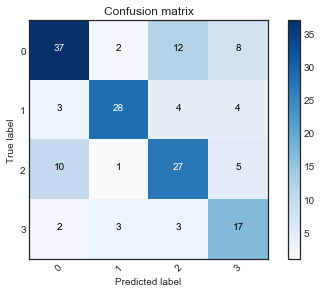

In [30]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(accuracy_score(preds, y))
print(classification_report(preds, y, target_names=data.classes))

0.6566265060240963
             precision    recall  f1-score   support

          0       0.71      0.63      0.67        59
          1       0.82      0.72      0.77        39
          2       0.59      0.63      0.61        43
          3       0.50      0.68      0.58        25

avg / total       0.67      0.66      0.66       166



In [ ]:
log_preds, y =  learn.TTA(is_test=True)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
print(preds)

In [32]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [33]:
embeddings = get_embeddings('14')

In [34]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(664, 512)
(166, 512)
(60, 512)
(664,)
(166,)
(60,)


In [35]:
import umap

In [60]:
y_test = np.zeros(60)
y_test[:30] = y_test[:30] +1 
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [57]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.4,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

In [58]:
# data.test_ds.fnames

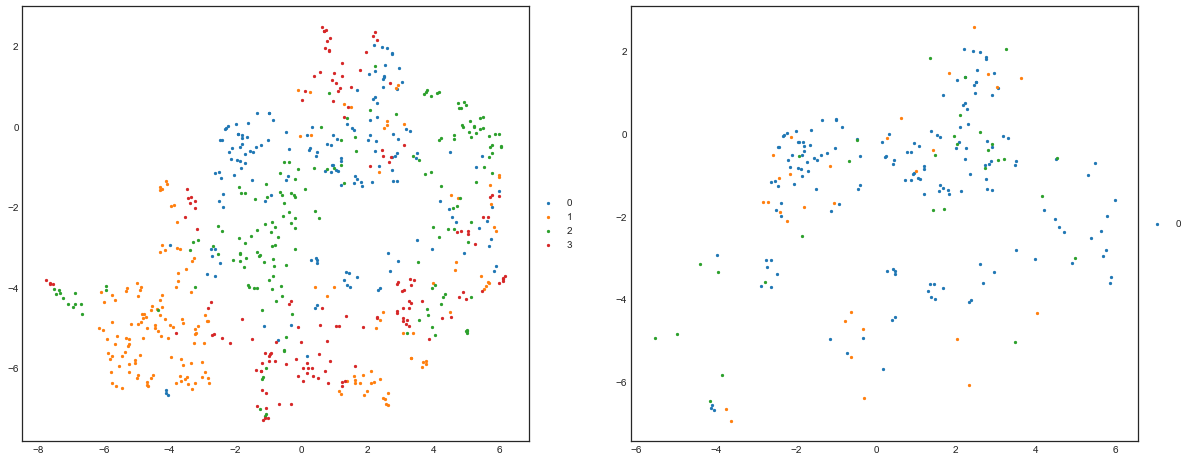

In [61]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(4):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)

#     axarr[0].set_xlim(-10,5)
#     axarr[0].set_ylim(-5,8)
    
for i in [0,1]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     axarr[1].set_xlim(-10,5)
#     axarr[1].set_ylim(-5,8)


In [ ]:
def opt_th(preds, targs, start=0.2, end=0.6, step=0.05):
    ths = np.arange(start,end,step)
    res = [f1_macro(preds, targs, thresh=th, kind='macro') for th in ths]
    idx = np.argmax(res)
    return ths[idx], res

In [ ]:
# get train predictions

preds_trn, targs_trn =  learn.predict_with_targs('trn')

preds_trn_torch = torch.from_numpy(preds_trn)
targs_trn_torch = torch.from_numpy(targs_trn)

opt_th(preds_trn_torch, targs_trn_torch)

In [ ]:
print(preds_val_torch[0])
print(preds_trn_torch[0])

In [ ]:
# get val predictions

preds_val, targs_val =  learn.predict_with_targs('val')

preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

In [ ]:
# get test predictions

preds_test, targs_test =  learn.predict_with_targs('test')

In [ ]:
targs_test[:50]

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
data.test_dl.sampler

In [ ]:
test_names = data.test_ds.fnames
test_names[:10]

In [ ]:
def create_submission(preds_file, output_name, th = 0.3, TTA=False):
    
    # creating submission file
    
    if TTA:
        preds = preds_file.mean(axis=0)
        print('TTA:',preds.shape)
    else: preds = preds_file
    
    clss = np.arange(0, len(data.classes)) # get class indeces
    res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > th)])) for p in preds]) # generating output

    # ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
    for i in range(res.shape[0]):
        if res[i] == '':
            res[i] = preds[i].argmax()

    # getting image Ids
    fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

    # creating submission file
    sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
    sub_df.to_csv(output_name, index_label='Id')

In [ ]:
submission_name = PATH + 'submissions/Res18_pre_0.42_t-03.csv'

create_submission(log_preds, submission_name, th=0.3, TTA=True)

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [ ]:
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 1000)
# score = 0.0
# test_threshold=0.5*np.ones(28)
# best_threshold=np.zeros(28)
# best_val = np.zeros(28)
# for i in range(28):
#     for threshold in thresholds:
#         test_threshold[i] = threshold
#         max_val = np.max(preds_y)
#         val_predict = (preds_y > test_threshold)
#         score = f1_score(valid_y > 0.5, val_predict, average='macro')
#         if score > best_val[i]:
#             best_threshold[i] = threshold
#             best_val[i] = score
#     print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
#     test_threshold[i] = best_threshold[i]
# print("Best threshold: ")
# print(best_threshold)
# print("Best f1:")
# print(best_val)